# CNN Classifier: Dogs & Cats

To cover the basics in Convolutional Neural Networks, a simple walkthrough of how a binary classifier works on traditional machine learning approaches is done. Here, the dataset of 3000 dogs and 3000 cat pictures were collected prior to working on this workbook.

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


### Prep-Work
<font color=blue>This section has 3 phases for input data generation: the directory creation, the resizing, and the image batch generator. The section below covers the functions used for creating the directory, which has if-else statements to remake the train/test/valid contents per run, shuffling each time. The files will then be copied over from a shuffled collection of cats/dogs.</font>

In [2]:
import shutil
def directory_import(dataset,location):
    for file in dataset:
        shutil.copy(file, location)

def directory_creation(directory):
    if os.path.exists(directory):
#         print('path exists! deleting')
        shutil.rmtree(directory)
    if not os.path.exists(directory):
#         print('empty! making directory')
        os.makedirs(directory)
    
def image_to_array(dataset):
    x = []
    for image in dataset:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    return x

<font color=blue>Each run, 80% of the overall shuffled cats/dogs will be set into the train folder, 10% into valid, and the remaining 10% into the test folder. Note that this approach copies the images, so runtime will take a while.</font>

In [3]:
img_width = 50
img_height = 50
num_classes = 2
DATA_DIR = './data/'
image_filenames = [DATA_DIR+i for i in os.listdir(DATA_DIR)] # use this for full dataset

# Split the data in three sets, 80% for training, 10% for validation and 10% for testing
train_dir = './data/train/'
directory_creation(train_dir)
directory_creation(train_dir+'cat/')
directory_creation(train_dir+'dog/')
valid_dir = './data/valid/'
directory_creation(valid_dir)
directory_creation(valid_dir+'cat/')
directory_creation(valid_dir+'dog/')
test_dir = './data/test/'
directory_creation(test_dir)
directory_creation(test_dir+'cat/')
directory_creation(test_dir+'dog/')


cat_filenames = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]
np.random.shuffle(cat_filenames)
dog_filenames = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
np.random.shuffle(dog_filenames)
# print(len(cat_filenames),len(dog_filenames))
# print(cat_filenames[0],dog_filenames[0])
cat_train = cat_filenames[int(len(cat_filenames) * 0) : int(len(cat_filenames) * .8)]
dog_train = dog_filenames[int(len(dog_filenames) * 0) : int(len(dog_filenames) * .8)]
directory_import(cat_train, train_dir+'cat/')
directory_import(dog_train, train_dir+'dog/')
# print(len(cat_train),len(dog_train))
train_data = cat_train + dog_train
np.random.shuffle(train_data)
train_label = [[0] if 'cat' in i else [1] for i in train_data]
# directory_import(train_data,train_dir)


cat_valid = cat_filenames[int(len(cat_filenames) * 0.8) : int(len(cat_filenames) * .9)]
dog_valid = dog_filenames[int(len(dog_filenames) * 0.8) : int(len(dog_filenames) * .9)]
directory_import(cat_valid, valid_dir+'cat/')
directory_import(dog_valid, valid_dir+'dog/')
# print(len(cat_label),len(dog_label))
valid_data = cat_valid+dog_valid
np.random.shuffle(valid_data)
valid_label = [[0] if 'cat' in i else [1] for i in valid_data]
# directory_import(valid_data,valid_dir)


cat_test = cat_filenames[int(len(cat_filenames) * 0.9) : int(len(cat_filenames) * 1)]
dog_test = dog_filenames[int(len(dog_filenames) * 0.9) : int(len(dog_filenames) * 1)]
directory_import(cat_test, test_dir+'cat/')
directory_import(dog_test, test_dir+'dog/')
# print(len(cat_test),len(dog_test))
test_data = cat_test + dog_test
np.random.shuffle(test_data)
test_label = [[0] if 'cat' in i else [1] for i in test_data]
# directory_import(test_data,test_dir)


<font color=blue>While this section is no longer used, it was kept in the event an error occurs with the `flow_from_directory` method below. This approach uses the flow(x,y) from the generated data as a backup. The datasets are resized and given their labels. The data format output given indicates the `(count, image_width, image_height, channel_count)`, with the channels being RGB</font>

In [4]:
from keras import backend as K

# train_data = [train_dir+i for i in os.listdir(train_dir)]
X_train = image_to_array(train_data)
Y_train = train_label
print(K.image_data_format(), np.array(X_train).shape)
# valid_data = [valid_dir+i for i in os.listdir(valid_dir)]
X_valid = image_to_array(valid_data)
Y_valid = valid_label
print(K.image_data_format(), np.array(X_valid).shape)
# test_data = [test_dir+i for i in os.listdir(test_dir)]
X_test = image_to_array(test_data)
Y_test = test_label
print(K.image_data_format(), np.array(X_test).shape)

channels_last (4800, 50, 50, 3)
channels_last (600, 50, 50, 3)
channels_last (600, 50, 50, 3)


<font color = blue>Each directory is used to make the batch generators, notably having the training set undergo additional pre-processing (not the valid/test, since those are to be tested on). Each set is rescaled and uses the `flow_from_directory` approach, with the chosen standard batch size of 32 (_50 was considered, but it would need 100 epochs to truly show effect_), and the class mode as binary rather than categorical (_since there are only 2 outcomes, cat/dog_) <br> One thing that must be noted is that the training/valid generators have shuffle enabled, but the test generator does not. This is to prevent variance in the results when comparing later (_will be explained further down_)</font>

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
datagen = ImageDataGenerator(rescale=1/255)
batch_size=32
# train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=32)
train_gen = train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size,
                                              class_mode='binary',shuffle=True)
# validation_generator = datagen.flow(np.array(X_valid), Y_valid, batch_size=32)
valid_gen = datagen.flow_from_directory(valid_dir,target_size=(img_width,img_height),batch_size=batch_size,class_mode='binary',
                                        shuffle=True)
# test_generator = datagen.flow(np.array(X_test), Y_test, batch_size=32)
test_gen = datagen.flow_from_directory(test_dir,target_size=(img_width,img_height),batch_size=batch_size,class_mode='binary',
                                       shuffle=False)

Found 4800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Model Structure

<font color=blue>A basic sequential model, consisting of 3 stacked convolutional+pooling 2D layers were used for the initial run(_originally 2 were used, but the results were awful_) with a flat layer, followed by 2 activation functions: reLu and sigmoid. Sigmoid is placed at the last since it is a binary classification problem</font>

In [6]:
# Add your code here
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flat

<font color=blue>When fitting the generator into the model, the epochs was set to 25, as the ideal range for a relatively small dataset would be between 15-30. Note that whilst training, the validation accuracy fluctuations occasionally spiked. This is likely due to the dataset containing one of the few 'fake' images (_dog.1773.png for example is not a dog, yet named as one_). Deleting them would have a disparity in overall dataset distribution, which means to balance it, each dataset would need to be trimmed further. This variance is just taken into account when viewing the results</font>

In [7]:
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=100,
    epochs=25,
    validation_data=valid_gen,
    validation_steps=50,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
100/100 [==============================] - 19s 188ms/step - loss: 0.7156 - acc: 0.5147 - val_loss: 0.8040 - val_acc: 0.5038
Epoch 2/25
100/100 [==============================] - 18s 176ms/step - loss: 0.6730 - acc: 0.5950 - val_loss: 0.6238 - val_acc: 0.6523
Epoch 3/25
100/100 [==============================] - 19s 191ms/step - loss: 0.6403 - acc: 0.6509 - val_loss: 0.6246 - val_acc: 0.6168
Epoch 4/25
100/100 [==============================] - 17s 174ms/step - loss: 0.6103 - acc: 0.6641 - val_loss: 0.6158 - val_acc: 0.6320
Epoch 5/25
100/100 [==============================] - 17s 171ms/step - loss: 0.5884 - acc: 0.6853 - val_loss: 0.5522 - val_acc: 0.7069
Epoch 6/25
100/100 [==============================] - 17s 171ms/step - loss: 0.5772 - acc: 0.7056 - val_loss: 0.6878 - val_acc: 0.6067
Epoch 7/25
100/100 [==============================] - 17s 171ms/step - loss: 0.5653 - acc: 0.7116 - val_loss: 0.5798 - val_acc: 0.6624
Epoch 8

### Evaluation
<font color = blue>Functions were made to print the classification results of a given model, which can be reused later when testing the improved model. The frist prints the accuracy score, the classification report, the confusion matrix, ROC curve, Precision Recall Curve, and the other prints the training and validation loss/accuracy curves from the model's history <br> It is also worth noting that the positive label is set to dogs (1)</font>

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score, accuracy_score

def results(prediction, label):
    print('accuracy: ', round(accuracy_score(label,prediction),4))
    print('classification report:')
    print(classification_report(label,prediction, target_names=['cat','dog']))
    print('Confusion Matrix:')
    cm = confusion_matrix(label, prediction, labels=[0,1])
    print(cm)
    
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.suptitle('ROC Curve')

    ax1 = plt.subplot()
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR')
    FPR_p,TPR_p, thresholds_p = roc_curve(label,prediction,pos_label=1)
    ax1.plot(FPR_p,TPR_p, label='Precision-Recall CNN')
    
    fig1 = plt.figure()
    average_precision = average_precision_score(label, prediction, pos_label=1)
    precision,recall, _ = precision_recall_curve(label,prediction,pos_label=1)
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

def model_timeline(model):
    accuracy = model.history['acc']
    val_accuracy = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(accuracy))
    figure3 = plt.figure()
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

<font color=blue>Given that the accuracy is dependent on which class is chosen (_because it is binary_), the score is dependent on whether the desired class is 0, or 1. For that reason, the results are dependent on the criteria whether the predicted result should be 0 (less than 0.5), or 1 (more than 0.5), which is the assumed sigmoid standard. <br> That being said, the model seems to consistently have an easier time identifying dogs throughout reruns, and a harder time identifying cats. This is tested later in the improved model, but the 'fake' images (_multiple instances of the fake images include cat photos labelled as dogs_), and relative poor quality of images displaying key cat features could have been a possible factor.</font>

accuracy:  0.7733
classification report:
              precision    recall  f1-score   support

         cat       0.74      0.79      0.76       278
         dog       0.81      0.75      0.78       322

   micro avg       0.77      0.77      0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.78      0.77      0.77       600

Confusion Matrix:
[[221  57]
 [ 79 243]]


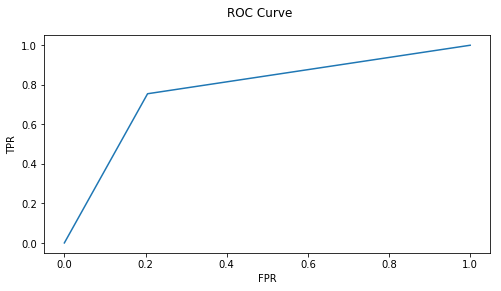

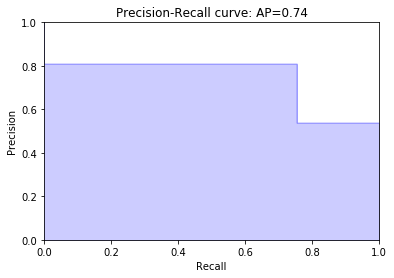

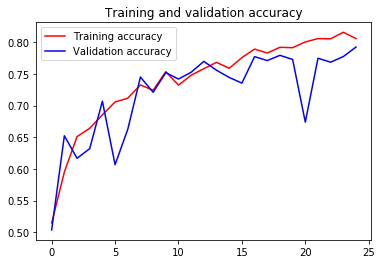

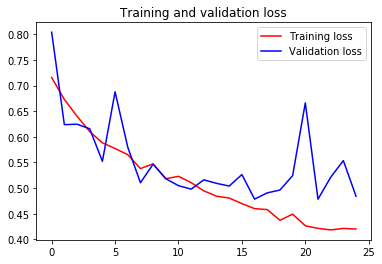

In [9]:
# Add your code here
Y_predict= model.predict_generator(test_gen, steps=len(X_test)/32)
Y_predict = (Y_predict>0.5)
y_true = test_gen.classes
results(y_true,Y_predict)
model_timeline(history)

### Parameter Tweaking
<font color=blue>Multiple experimentations were done prior to this version, but the various ways explored were: 
- **Layer count**: Adding additional layers improved performance for the most part, but adding too many layers caused a decrease in performance (This was with the 20-30 epoch count. Whilst 100 epochs would show a better difference, the runtime was too long)
- **Epochs**: Fluctuations occured, but increasing the epoch count generally helped improve the overall performance, until very high epoch amounts resulted in the training data being overfitted, and the validation data accuracy plummeting.
- **Filter amount**: This factor proved to have the highest impact on performance, in which using filter amounts bigger than the image width/height resulted in awful accuracy results (128 would not work well on a 50x50)  
- **Optimizer type**: Experimented with Adam and RMSProp, but no visible difference was found 
- **Dropout**: To prevent overfitting, a dropout value of 0.25 was used (50% felt too large for this dataset size)
- **Steps Count**: Steps count did have a minor improvement, but the runtime was so slow it was ommitted.
</font>

In [10]:
from keras import optimizers
# Add your code here
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(50, 50, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model.add(Dense(512, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<font color=blue>Once again, the validation fluctuations could be accounted from the fake images, aswell as the dropout layer. </font>

In [11]:
# Add your code here
history1= model1.fit_generator(train_gen,steps_per_epoch=100,epochs=30,
                               validation_data=valid_gen,validation_steps=50, workers=12)

Epoch 1/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6956 - acc: 0.5075 - val_loss: 0.6888 - val_acc: 0.5622
Epoch 2/30
100/100 [==============================] - 10s 95ms/step - loss: 0.6875 - acc: 0.5425 - val_loss: 0.6659 - val_acc: 0.6142
Epoch 3/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6684 - acc: 0.5938 - val_loss: 0.6516 - val_acc: 0.5985
Epoch 4/30
100/100 [==============================] - 11s 106ms/step - loss: 0.6506 - acc: 0.6209 - val_loss: 0.6808 - val_acc: 0.5698
Epoch 5/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6432 - acc: 0.6403 - val_loss: 0.7034 - val_acc: 0.5723
Epoch 6/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6437 - acc: 0.6328 - val_loss: 0.6063 - val_acc: 0.6660
Epoch 7/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6242 - acc: 0.6619 - val_loss: 0.6030 - val_acc: 0.6618
Epoch 8/30
100/100 [==============================] - 13

<font color=blue>Nonetheless, the resultant validation accuracy/loss improved from the previous model (_The validation loss is lower than training, accuracy similiar to training compared to the previous model_), with the overall classification accuracy improving by ~0.5 (_varies per shuffle run_). The ROC remains unchanged, precision-recall improves in the runs performed, and dogs once again appear to be easily classified compared to cats, which appears harder to classify given additional layers (_once again, possibly due to the fake images_).</font>

accuracy:  0.7183
classification report:
              precision    recall  f1-score   support

         cat       0.58      0.80      0.67       215
         dog       0.86      0.67      0.75       385

   micro avg       0.72      0.72      0.72       600
   macro avg       0.72      0.74      0.71       600
weighted avg       0.76      0.72      0.72       600

Confusion Matrix:
[[173  42]
 [127 258]]


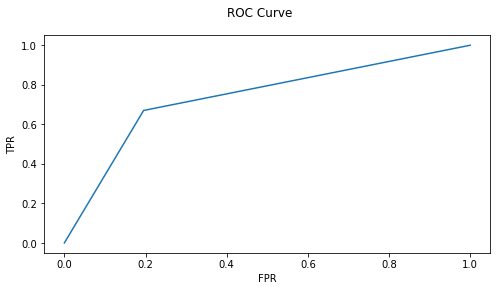

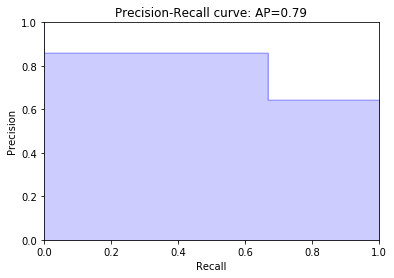

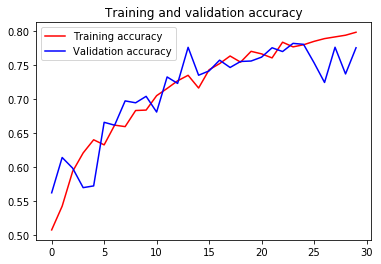

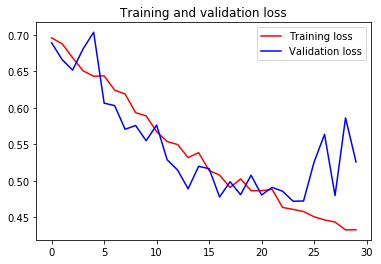

In [12]:
Y_predict= model1.predict_generator(test_gen, steps=len(test_data)/32)
Y_predict = (Y_predict>0.5)
results(y_true,Y_predict)
model_timeline(history1)

### Saliency Map
 Ever wondered what goes on inside the CNN? Well, this section goes into what each layer visualizes per training cycle. Much like in regular machine learning, feature selection is done, adding weights to certain pixels of an image to prioritize in finding out if the image is X or Y (In this case, cat vs dog)

<font color=blue>This section focused on determining what features are considered by each layer/filter when training. Because dogs were so commonly classified, the focus was on a dog image. This section displays the visual composition of the layer's filters, and what is considered. Layer 3 in this example, only takes green pixels into account, which would be the grass. </font>

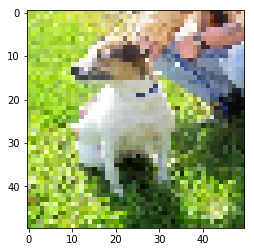

(1, 48, 48, 32)


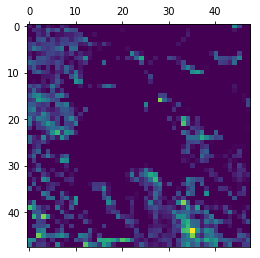

In [50]:
from keras.preprocessing import image
from keras import applications, models

# Add your code here
img = image.load_img(train_data[10],target_size=(50,50))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

layer_outputs = [layer.output for layer in model1.layers[:8]]
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 3], cmap='viridis')

<font color=blue>The overall saliency map was plotted per each filter, in each layer, to visualize the features considered, down to the dense layer. The assumption is that the most useful features are encoded and carried forward to the next layer, which repeats until a decision can be made from analyzing said features. Distinctive features such as the snout (3rd square from the topleft and bottom-left 3 squares) for example, is carried over until the flatten layer, which is unique to dogs and not cats.</font>

C:\Users\recon\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


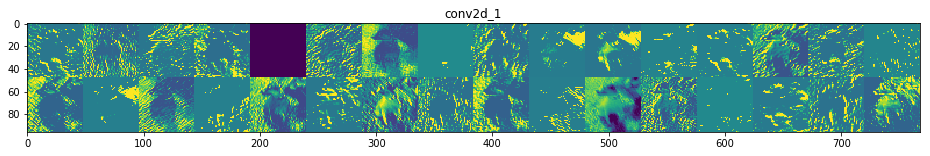

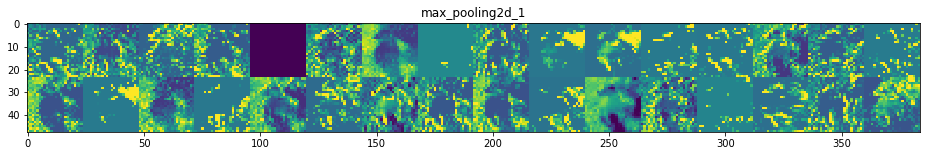

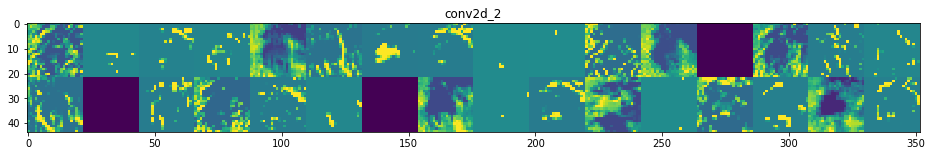

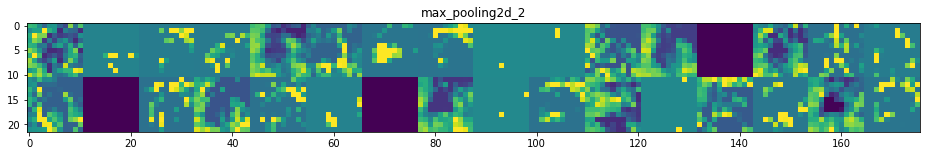

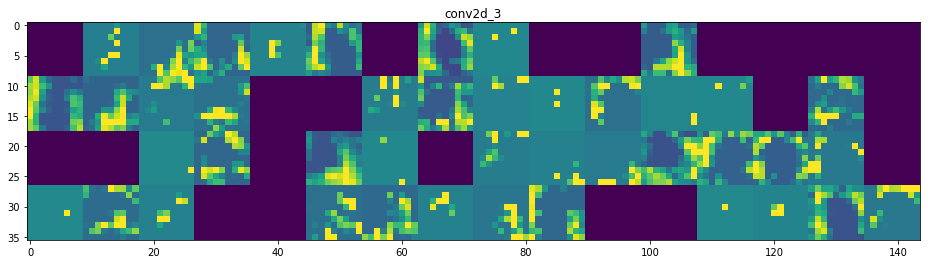

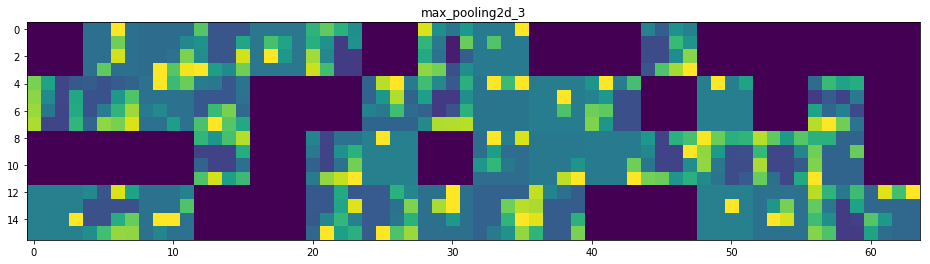

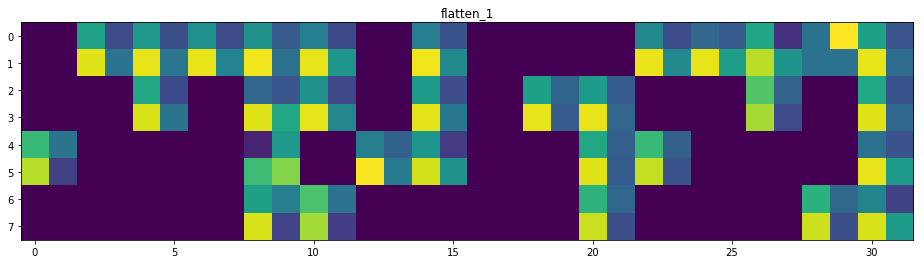

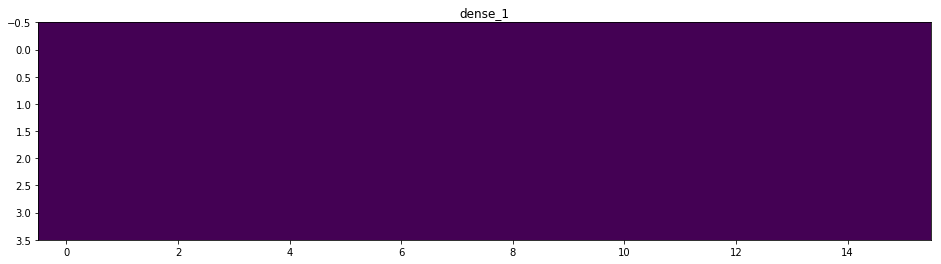

In [44]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

And that's all! 
CNN classification is actually significantly easier to handle than your traditional Bayes ML due to there being an automatic feature selection technique, which will eventually be expanded upon (This workbook) next time to include camera footage, where object detection is done on the fly!!

## -Aaron T.